In [40]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_analysis.utils import user
from data.paths.parquet_paths import USER, REVIEW

In [41]:
user_df = pd.read_parquet(str(USER))
review_df = pd.read_parquet(str(REVIEW))

In [42]:
user_df = user.prepare_user_df(user_df)

In [43]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             10000 non-null  object        
 1   name                10000 non-null  object        
 2   review_count        10000 non-null  int32         
 3   yelping_since       10000 non-null  datetime64[ns]
 4   friends             10000 non-null  object        
 5   useful              10000 non-null  int32         
 6   funny               10000 non-null  int32         
 7   cool                10000 non-null  int32         
 8   fans                10000 non-null  int32         
 9   elite               0 non-null      object        
 10  average_stars       10000 non-null  float32       
 11  compliment_hot      10000 non-null  int32         
 12  compliment_more     10000 non-null  int32         
 13  compliment_profile  10000 non-null  int32      

In [44]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float32
 4   date         100000 non-null  object 
 5   text         100000 non-null  object 
 6   useful       100000 non-null  int32  
 7   funny        100000 non-null  int32  
 8   cool         100000 non-null  int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 5.3+ MB


In [50]:
# user_df['user_id'] = user_df['user_id'].astype(str)
# review_df['user_id'] = review_df['user_id'].astype(str)

user_columns = [
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    # 'useful',
    # 'funny',
    # 'cool',
    'fans',
    'average_stars'
]


review_user_df = review_df.join(user_df[user_columns].set_index('user_id'), on='user_id')

In [51]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   review_id      100000 non-null  object        
 1   user_id        100000 non-null  object        
 2   business_id    100000 non-null  object        
 3   stars          100000 non-null  float32       
 4   date           100000 non-null  object        
 5   text           100000 non-null  object        
 6   useful         100000 non-null  int32         
 7   funny          100000 non-null  int32         
 8   cool           100000 non-null  int32         
 9   name           8279 non-null    object        
 10  review_count   8279 non-null    float64       
 11  yelping_since  8279 non-null    datetime64[ns]
 12  fans           8279 non-null    float64       
 13  average_stars  8279 non-null    float32       
dtypes: datetime64[ns](1), float32(2), float64(2), int32(3

In [53]:
review_user_df = review_user_df.loc[~review_user_df['name'].isna()].copy()

In [54]:
review_user_df.sample(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
55317,yR-etdpAsLcOMkzEY0kZyg,kn1ya_7VhGLx7iyl_sSc9w,seYvTmOZGJ2IAMdfQa8pkg,4.0,2009-10-20,Cute! I love another independent coffee shop i...,1,0,1,Megan,186.0,2007-09-20 01:23:27,36.0,3.53
88371,mpGWKNZCD3KewUMIkz5idw,ov9G-Mn1XGFp6m8sFEmEng,8jlSRdjL4ARMhS3gXrqJmQ,4.0,2010-11-22,Kiosk style multi tap bar/area. Its a nice pla...,1,0,1,Erin,549.0,2009-08-21 17:28:19,55.0,4.05


<AxesSubplot: >

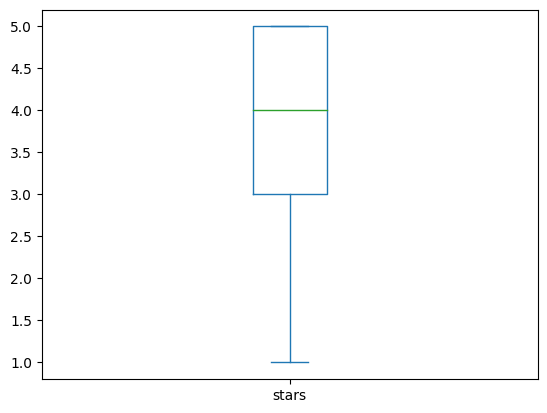

In [65]:
review_user_df.groupby('user_id')['stars'].mean().plot(kind='box')